#1.前準備


##必要なライブラリやモジュールの準備

In [ ]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title 実行環境選択とスタートアップ { display-mode: "form" }

from enum import Enum

class Mode(Enum):
    jupyter = 1
    colab = 2

mode = Mode.colab #@param ["Mode.colab","Mode.jupyter"] {type:"raw"}

if mode == Mode.colab:
    #from google.colab import drive #インポート
    #drive.mount('/content/gdrive') #GoogleDriveのマウント
    
    !pip install pytorch_lightning --quiet
    !pip install wget --quiet
    !pip install einops --quiet
    !pip install essentia --quiet
    !pip install Signal_Analysis --quiet
    #!pip install torch torchaudio --quiet
    #!pip install torch --quiet
    #!pip install librosa --quiet

from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple
from torch.utils.data import DataLoader, Dataset #追加
from einops import rearrange

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional
import torch.optim as optim
import torchvision
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F
import gdown
import random
import numpy as np
import os
import essentia, essentia.standard as ess
import essentia.streaming

## ユーティリティ関数達

In [ ]:
#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------
import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
import requests
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio, display


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  #waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  #waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None): #2Dのデータを表示
  fig, axs = plt.subplots(1, 1) #FigureとAxesを作成
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect) #imshow: 画像出力
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_wav2specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    #waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

def align_seconds(wav,sr =16000, second=3):
    wav = wav[:,:sr*second]
    return wav

def model_eval(wav):
    with torch.no_grad():
        model.eval()
        spec = model(wav.to(model.device))
        model.train()
    return spec

##データセットダウンロード

In [ ]:
import shutil #zip解凍用

FILENAME = "AKWF_44k1_600s"
DOWNLOAD_NAME = FILENAME + ".zip"
ID = "1XNTe_b8I19jzHrTGMJKUeyTj7QdjoK-v"
URL = "https://drive.google.com/uc?id=" + ID

#既にダウンロード済みであったらダウンロードしないように変更
def download_dataset():
  cwd = os.getcwd()
  if os.path.exists(os.path.join(cwd, DOWNLOAD_NAME)):
      return
  else: # Datasetダウンロードとunzip
    gdown.download( URL , DOWNLOAD_NAME , quiet=True) #全部で4158個のファイル
    shutil.unpack_archive(DOWNLOAD_NAME)

download_dataset()
NUM_TRAIN = 3158 #trainの数
NUM_VAL = 1000 #valの数

In [ ]:
import shutil #zip解凍用

FILENAME = "six_cycle_wave"
DOWNLOAD_NAME = FILENAME + ".zip"
ID = "1qoBHymVOoD937eYXJT4mEkGdtW7zxpgp"
URL = "https://drive.google.com/uc?id=" + ID

#既にダウンロード済みであったらダウンロードしないように変更
def download_dataset():
  cwd = os.getcwd()
  if os.path.exists(os.path.join(cwd, DOWNLOAD_NAME)):
      return
  else: # Datasetダウンロードとunzip
    gdown.download( URL , DOWNLOAD_NAME , quiet=True) #全部で4158個のファイル
    shutil.unpack_archive(DOWNLOAD_NAME)

download_dataset()

In [ ]:
#当該フォルダに保存できたか確認
wavepath = list(Path(FILENAME).glob("**/*.wav"))
print(wavepath[:3])

[PosixPath('six_cycle_wave/AKWF_44k1_600s/AKWF_dbass_0049.wav'), PosixPath('six_cycle_wave/AKWF_44k1_600s/AKWF_eorgan_0003.wav'), PosixPath('six_cycle_wave/AKWF_44k1_600s/AKWF_0757.wav')]


# 2.各クラスの作成

## Datasetクラスの作成

In [ ]:
import json
from os import path

#参考 : https://github.com/morris-frank/nsynth-pytorch/blob/master/nsynth/data.py

class AKWDDataset(torch.utils.data.Dataset):

    # downladed from Adventure Kid Research & Technology (AKRT) website.
    # Link : https://www.adventurekid.se/akrt/waveforms/adventure-kid-waveforms/
    # deleated streo data. (200data)

    def __init__(self, root): #ここでファイル名変更　”nsynth-subset” or "nsynth-test/audio"
        super().__init__()
        self.root = root
        self.wave_paths = [str(p) for p in Path(self.root).glob("**/*.wav")]
        print(self.wave_paths)
        print(f'Loading AKWD data from {self.root}')
        print(f'\tFound {len(self)} samples.')
        assert len(self) > 0, f'No samples found in {self.root}'


    def __len__(self):
        return len(self.wave_paths)

    def __getitem__(self, idx: int)-> Tuple[Any, Any]:

        #Args:
        #    index (int): Index
        #Returns:
        #    tuple: (image, target) where target is index of the target class.

        #入力
        audio, sample_rate = torchaudio.load(self.wave_paths[idx])
        ess_audio = ess.MonoLoader(filename=self.wave_paths[idx])()
        
        # wave_paths[idx]
        with open(f'AKWF_44k1_600s/labels/{Path(self.wave_paths[idx]).stem}_analysis.json', 'r') as fp:
            attrs = json.load(fp)

        #attrs['audio'] = waveform
        attrs['name'] = Path(self.wave_paths[idx]).name

        return audio , attrs ,ess_audio

# Essentia

## スタートアップ

In [ ]:
# Common Settings
%matplotlib inline 
import statistics
import torch
import matplotlib.pyplot as plt
import Signal_Analysis.features.signal as signal
import essentia.streaming as esss

ToDB =  torchaudio.transforms.AmplitudeToDB(stype = 'power')#,top_db = 50)

if mode == Mode.jupyter:
    dataset = AKWDDataset(root="AKWF_44k1_600s")
elif mode == Mode.colab:
    #dataset = AKWDDataset(root="/content/AKWF_44k1_600s")
    dataset = AKWDDataset(root="/content/six_cycle_wave/AKWF_44k1_600s")

#インスタンス化
centroid = ess.Centroid()
centralMoments = ess.CentralMoments()
distributionShape = ess.DistributionShape()
zeroCrossingRate = ess.ZeroCrossingRate()
spectrum = ess.Spectrum(size=3600)
powerSpectrum = ess.PowerSpectrum(size=3600)
tensorToVectorReal = esss.TensorToVectorReal()

spectralPeaks = ess.SpectralPeaks()
spectalComplexity = ess.SpectralComplexity()
odd = ess.OddToEvenHarmonicEnergyRatio()
dissonance = ess.Dissonance()
pitchSalience = ess.PitchSalience()

['/content/six_cycle_wave/AKWF_44k1_600s/AKWF_dbass_0049.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_eorgan_0003.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_0757.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_0151.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_0156.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_1733.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_fmsynth_0031.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_1323.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_aguitar_0008.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_hdrawn_0014.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_eorgan_0034.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_ebass_0054.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_ebass_0067.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_1192.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_theremin_0006.wav', '/content/six_cycle_wave/AKWF_44k1_600s/AKWF_1452.wav', '/content/six_cycle_wave/AKWF_44k1_600s

## 関数

In [ ]:
import numpy
import json

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.integer):
            return int(obj)
        elif isinstance(obj, numpy.floating):
            return float(obj)
        elif isinstance(obj, numpy.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [ ]:
def min_max_for_list(list, comment, offset=0):
    l_min = min(list)
    print(comment + "_min = ", l_min)
    l_max = max(list)
    print(comment + "_max = ", l_max)
    return [(((i - l_min) / (l_max - l_min)) + offset)  for i in list]

def standardization(l):
    l_mean = statistics.mean(l)
    l_stdev = statistics.stdev(l)
    return [(i - l_mean) / l_stdev for i in l]

In [ ]:
def min_max(data, min, max):
    return (data - min) / (max - min)

In [ ]:
def boxplot(points : tuple, ticklabels: tuple): # 箱ひげ図
    fig, ax = plt.subplots(1,1,figsize=(20,10))

    bp = ax.boxplot(points) # 複数指定する場合はタプル型で渡します。
    ax.set_xticklabels(ticklabels)

    plt.title('Audio Extracter')
    plt.grid() # 横線ラインを入れることができます。

    # 描画
    plt.show()

In [ ]:
def waveToSpec(waveform: torch.Tensor, sample_points: int, db:bool=False ):
    spec =  torchaudio.transforms.Spectrogram(
                                                       n_fft = sample_points, #時間幅
                                                       hop_length = sample_points, #移動幅
                                                       win_length = sample_points, #窓幅
                                                       center=False,
                                                       pad=0, #no_padding
                                                       window_fn = torch.hann_window,
                                                       normalized=True,
                                                       onesided=True,
                                                       power=1.0)
        
    ToDB =  torchaudio.transforms.AmplitudeToDB(stype = 'magnitude')#,top_db = 50)
    combain_x = waveform.reshape(1, -1) # [3600] -> [1,3600]
    spec_x = spec(combain_x) # [1,3600] -> [901,1???]
    #print(spec_x.shape)
    if db:
        spec_x = ToDB(spec_x)

    return spec_x

In [ ]:
def ytn_audio_exatractor(audio: torch.Tensor, ess_audio:np.ndarray):
    
    spec = waveToSpec(audio,3600,db=False).reshape(-1).numpy()
    ess_spec = spectrum(ess_audio)

    c = centroid(ess_spec)
    sp, _, k = distributionShape(centralMoments(ess_spec))

    z = zeroCrossingRate(ess_audio)
    sc = spectalComplexity(ess_spec)
    freq , mag = spectralPeaks(ess_spec)

    o = odd(freq, mag)
    d = dissonance(freq, mag)
    ps = pitchSalience(ess_spec)
    h = signal.get_HNR(ess_audio, attrs['samplerate'])

    return c,sp,k,z,sc,o,d,ps,h

## スクリプト

In [ ]:
#綺麗に描き直してユーティリティー関数に入れる

def scw_combain(x,duplicate_num=6):

    """波形を6つくっつけてSTFTする関数

    Args:
        x (torch.Tensor): single cycle wavetable
        duplicate_num (int, optional): 何個連結するか設定. Defaults to 6.
    Returns:
        tmp (torch.Tensor): six cycle wavetable
    """

    for i in range(duplicate_num):
        if i == 0:
            tmp = x
        else:
            tmp = torch.cat([tmp, x],dim=1)

    return tmp

def _scw2spectrum(x,duplicate_num=6):

    """波形を6つくっつけてSTFTする関数

    Args:
        x (torch.Tensor): [description]
        duplicate_num (int, optional): [description]. Defaults to 6.
    Returns:
        tmp (torch.Tensor): [description]
    """

    batch_size = len(x[:])
    for i in range(batch_size):
        single_channel_scw = x[i,:,:] #[32,1,600] -> [1,1,600]

        if i == 0:
            tmp = _scw_combain_spec(single_channel_scw,duplicate_num) #[901,1]
        else:
            tmp = torch.cat([tmp, _scw_combain_spec(single_channel_scw,duplicate_num)]) #[901*i,1]

    #combain_spec = tmp.reshape(batch_size,-1) # [32,901,1]??
    return tmp

def _scw_combain_spec(scw,duplicate_num=6):

    scw = scw.reshape(-1) #[1,1,600] -> [600] #あとで直す
    #print("_scw2spectrum3",x.shape)

    for i in range(duplicate_num):
        if i == 0:
            tmp = scw
            #print("1",tmp.shape)
        else:
            tmp = torch.cat([tmp,  scw])
            #print("2",tmp.shape)

    spec_x = _specToDB(tmp.cpu()) # [3600] -> [1801,1]
    #print("test",spec_x.shape)
    return spec_x

def _specToDB(waveform):
    sample_points = len(waveform)
    spec =  torchaudio.transforms.Spectrogram(
                                                       #sample_rate = sample_rate,
                                                       n_fft = sample_points, #時間幅
                                                       hop_length = sample_points, #移動幅
                                                       win_length = sample_points, #窓幅
                                                       center=False,
                                                       pad=0, #no_padding
                                                       window_fn = torch.hann_window,
                                                       normalized=True,
                                                       onesided=True,
                                                       power=2.0)
        
    ToDB =  torchaudio.transforms.AmplitudeToDB(stype = 'power',top_db = 80)

    combain_x = waveform.reshape(1, -1) # [3600] -> [1,3600]
    spec_x = spec(combain_x) # [1,3600] -> [901,1???]
    spec_x = ToDB(spec_x)

    return spec_x

In [ ]:
class BaseActivationFunc(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

class Sigmoid(BaseActivationFunc):
    
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

class Tanh(BaseActivationFunc):
    
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

class ReLU(BaseActivationFunc):
    
    def forward(self, x):
        return x * (x > 0).float()

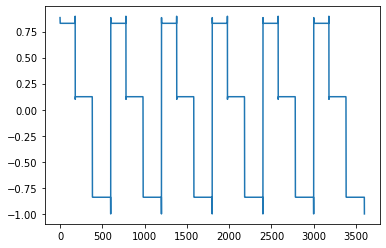

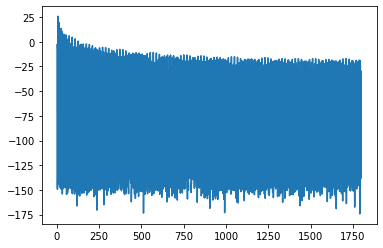

overdrive


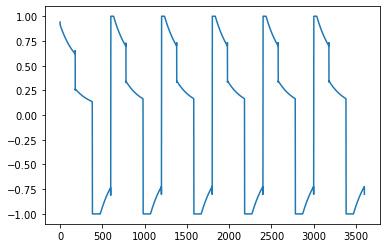

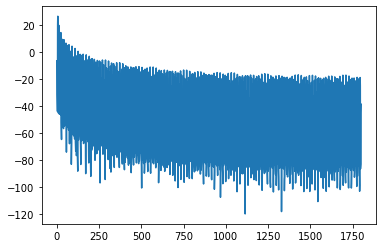

highpass


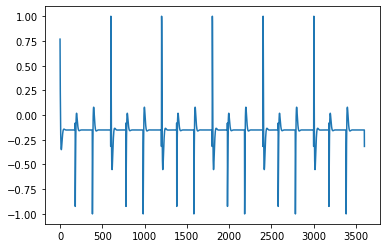

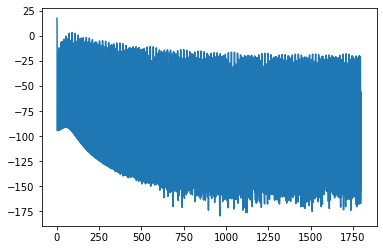

lowpass


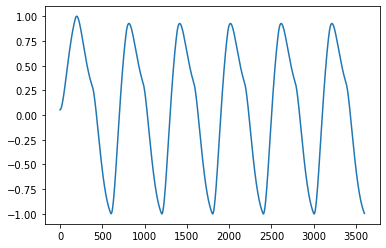

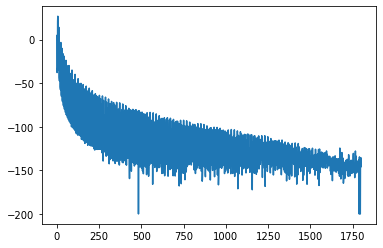

sigmoid


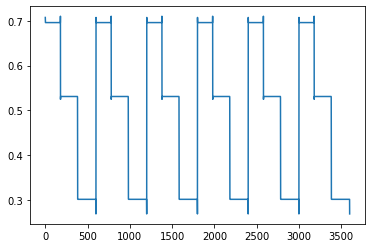

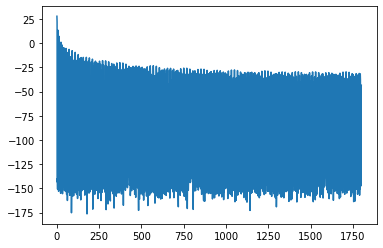

Tanh


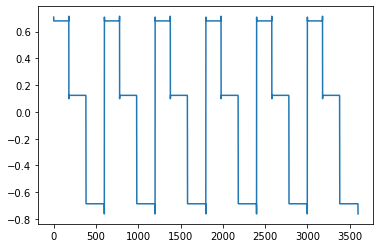

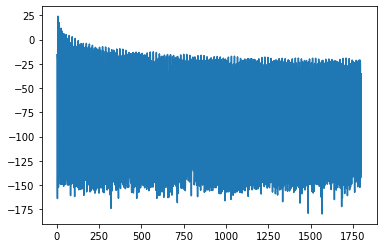

ReLU


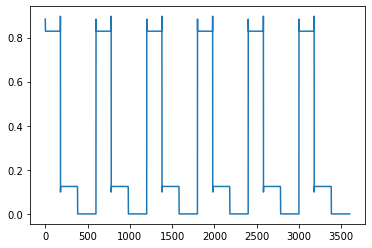

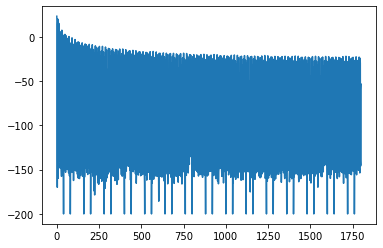

In [ ]:
def minmax_tensor(data):
    data = (data - torch.min(data)*torch.ones(data.shape)) / (torch.max(data)*torch.ones(data.shape) - torch.min(data)*torch.ones(data.shape)) *2 - 1
    return data

"""
def min_max(data, min, max):
    return (data - min) / (max - min)
"""


import torchaudio

# 音声データを読み込む
idx = 7
waveform, attrs, ess_audio = dataset[idx]

plt.figure()
plt.plot(waveform[0,:].numpy())
plt.show()

spec = waveToSpec(waveform,3600,True)
plt.plot(spec.squeeze())
plt.show()

# 音声に歪みを追加する
print("overdrive")
augmented_waveform = torchaudio.functional.overdrive(waveform, gain=100, colour=100)
plt.plot(augmented_waveform[0,:].numpy())
plt.show()

spec = waveToSpec(augmented_waveform,3600,True)
plt.plot(spec.squeeze())
plt.show()

"""
# overdrive
波形( Tensor ) – (…, time)の次元の音声波形
gain ( float、optional ) – dB 単位のブースト (または減衰) での目的のゲイン 値の許容範囲は 0 から 100 です
color ( float , optional ) – オーバードライブ出力の偶数高調波成分の量を制御します 値の許容範囲は 0 から 100 です
"""

# 音声にフィルタを追加する
print("highpass")
augmented_waveform = torchaudio.functional.highpass_biquad(waveform, attrs["samplerate"], 1000)
augmented_waveform = minmax_tensor(augmented_waveform)
augmented_waveform = augmented_waveform.numpy()
plt.plot(augmented_waveform[0,:])
plt.show()

spec = waveToSpec(torch.from_numpy(augmented_waveform),3600,True)
plt.plot(spec.squeeze())
plt.show()

# low pass
print("lowpass")
augmented_waveform = torchaudio.functional.lowpass_biquad(waveform, attrs["samplerate"], 100)
augmented_waveform = minmax_tensor(augmented_waveform)
augmented_waveform = augmented_waveform.numpy()
plt.plot(augmented_waveform[0,:])
plt.show()

spec = waveToSpec(torch.from_numpy(augmented_waveform),3600,True)
plt.plot(spec.squeeze())
plt.show()

# sigmoid
print("sigmoid")
sigmoid = Sigmoid()
augmented_waveform = sigmoid(waveform)
#augmented_waveform = minmax_tensor(augmented_waveform)
augmented_waveform = augmented_waveform.numpy()
plt.plot(augmented_waveform[0,:])
plt.show()

spec = waveToSpec(torch.from_numpy(augmented_waveform),3600,True)
plt.plot(spec.squeeze())
plt.show()

# Tanh
print("Tanh")
activation = Tanh()
augmented_waveform = activation(waveform)
#augmented_waveform = minmax_tensor(augmented_waveform)
augmented_waveform = augmented_waveform.numpy()
plt.plot(augmented_waveform[0,:])
plt.show()

spec = waveToSpec(torch.from_numpy(augmented_waveform),3600,True)
plt.plot(spec.squeeze())
plt.show()

# ReLU
print("ReLU")
activation = ReLU()
augmented_waveform = activation(waveform)
#augmented_waveform = minmax_tensor(augmented_waveform)
augmented_waveform = augmented_waveform.numpy()
plt.plot(augmented_waveform[0,:])
plt.show()

spec = waveToSpec(torch.from_numpy(augmented_waveform),3600,True)
plt.plot(spec.squeeze())
plt.show()

### 正規化

In [ ]:
def normalizationALL(minmax_offset_one_flg,yeojohnson_flg,minmax_flg, centro, spread, kurtosis, zeroX, oddfreq, pitchSali, HNR):

    if minmax_offset_one_flg:

        num = 1
        centro = min_max_for_list(centro,"c",offset=num)
        spread = min_max_for_list(spread,"sp",offset=num)
        kurtosis = min_max_for_list(kurtosis,"k",offset=num)
        zeroX = min_max_for_list(zeroX,"z",offset=num)
        #specComp = min_max_for_list(specComp,"sc")
        oddfreq = min_max_for_list(oddfreq,"o",offset=num)
        #disso = min_max_for_list(disso,"d")
        pitchSali = min_max_for_list(pitchSali,"ps",offset=num)
        HNR =min_max_for_list(HNR,"h",offset=num)

    if yeojohnson_flg:
        centro, centro_lmbda = stats.yeojohnson(centro)
        spread, spread_lmbda = stats.yeojohnson(spread)
        kurtosis, kurtosis_lmbda = stats.yeojohnson(kurtosis)
        zeroX, zeroX_lmbda = stats.yeojohnson(zeroX)
        oddfreq, oddfreq_lmbda = stats.yeojohnson(oddfreq)
        pitchSali, pitchSali_lmbda = stats.yeojohnson(pitchSali)
        HNR, HNR_lmbda = stats.yeojohnson(HNR)

        print("centro_lmbda = ",centro_lmbda)
        print("spread_lmbda = ",spread_lmbda)
        print("kurtosis_lmbda = ",kurtosis_lmbda)
        print("zeroX_lmbda = ",zeroX_lmbda)
        print("oddfreq_lmbda = ",oddfreq_lmbda)
        print("pitchSali_lmbda = ",pitchSali_lmbda)
        print("HNR_lmbda = ",HNR_lmbda)

    if minmax_flg:
        num = 0
        centro = min_max_for_list(centro,"c",offset=num)
        spread = min_max_for_list(spread,"sp",offset=num)
        kurtosis = min_max_for_list(kurtosis,"k",offset=num)
        zeroX = min_max_for_list(zeroX,"z",offset=num)
        #specComp = min_max_for_list(specComp,"sc")
        oddfreq = min_max_for_list(oddfreq,"o",offset=num)
        #disso = min_max_for_list(disso,"d")
        pitchSali = min_max_for_list(pitchSali,"ps",offset=num)
        HNR =min_max_for_list(HNR,"h",offset=num)

    return centro, spread, kurtosis, zeroX, oddfreq, pitchSali, HNR

In [ ]:
"""

#min_max出力用
from scipy import stats

class AudioFeatureNormalize4Dataset():

    def __init__(self):

        self.centro = []
        self.spread = []
        self.kurtosis = []
        self.zeroX = []
        self.oddfreq = []
        self.pitchSali = []
        self.HNR = []
        #self._feature_extract()

    def feature_extract(self,augment=None):

        for i in range(len(dataset)):

            # read audio
            audio, attrs, ess_audio = dataset[i]

            if augment == "lowpass":
                audio = torchaudio.functional.lowpass_biquad(audio, attrs["samplerate"], 100)
                audio = minmax_tensor(audio)

                ess_audio = torchaudio.functional.lowpass_biquad(torch.from_numpy(ess_audio), attrs["samplerate"], 100)
                ess_audio = minmax_tensor(ess_audio)
                ess_audio = ess_audio.numpy()

            elif augment == "highpass":
                audio = torchaudio.functional.highpass_biquad(audio, attrs["samplerate"], 2000)
                audio = minmax_tensor(audio)

                ess_audio = torchaudio.functional.highpass_biquad(torch.from_numpy(ess_audio), attrs["samplerate"], 2000)
                ess_audio = minmax_tensor(ess_audio)
                ess_audio = ess_audio.numpy()

            elif augment == "overdrive":
                audio = torchaudio.functional.overdrive(audio, gain=100, colour=100)
                ess_audio = torchaudio.functional.overdrive(torch.from_numpy(ess_audio), gain=100, colour=100)
                ess_audio = ess_audio.numpy()

            elif augment == "sigmoid":
                activation = Sigmoid()
                audio = activation(audio)
                ess_audio = activation(torch.from_numpy(ess_audio))
                ess_audio = ess_audio.numpy()

            elif augment == "relu":
                activation = ReLU()
                audio = activation(audio)
                ess_audio = activation(torch.from_numpy(ess_audio))
                ess_audio = ess_audio.numpy()   

            elif augment == "tanh":
                activation = Tanh()
                audio = activation(audio)
                ess_audio = activation(torch.from_numpy(ess_audio))
                ess_audio = ess_audio.numpy()

            audio_numpy = audio.numpy()
            ess_spec = spectrum(ess_audio)
            ess_power_spec = powerSpectrum(ess_audio)
            ess_spec_tensor = torch.Tensor(ess_spec)
            ess_spec_tensor = ToDB(ess_spec_tensor.reshape(1,-1))
            ess_spec_tensor = ess_spec_tensor.reshape(-1)

            reshape_audio = audio.reshape(1,-1)
            c,sp,k,z,sc,o,d,ps,h = ytn_audio_exatractor(audio,ess_audio)

            # append
            self.centro.append(c)
            self.spread.append(sp)
            self.kurtosis.append(k)
            self.zeroX.append(z)
            #specComp.append(sc)
            self.oddfreq.append(o)
            #disso.append(d)
            self.pitchSali.append(ps)
            self.HNR.append(h)

        return self.centro, self.spread, self.kurtosis, self.zeroX, self.oddfreq, self.pitchSali, self.HNR

audiof = AudioFeatureNormalize4Dataset()

audiof.feature_extract("lowpass")
audiof.feature_extract("highpass")
audiof.feature_extract("overdrive")
audiof.feature_extract("sigmoid")
audiof.feature_extract("relu")
audiof.feature_extract("tanh")

centro, spread, kurtosis, zeroX, oddfreq, pitchSali, HNR = audiof.feature_extract()

minmax_offset_one_flg = False
yeojohnson_flg = False
minmax_flg = True
normalizeMethodName = "ess_minmax"

centro, spread, kurtosis, zeroX, oddfreq, pitchSali, HNR = normalizationALL(minmax_offset_one_flg, yeojohnson_flg, minmax_flg, centro, spread, kurtosis, zeroX, oddfreq, pitchSali, HNR)

# 点数のタプル
points = (centro, spread, kurtosis, zeroX, oddfreq, pitchSali, HNR)
ticklabels = ["centro", "spread", "kurtosis", "zeroX", "oddfreq","pitchSali","HNR"]
boxplot(points,ticklabels)
"""
# loop終了
"""
for i in range(len(dataset)):

    audio, attrs, ess_audio = dataset[i]
    tmp_dict = {
        'SpectralCentroid': centro[i],
        'SpectralSpread': spread[i],
        'SpectralKurtosis': kurtosis[i],
        'ZeroCrossingRate': zeroX[i],
        'OddToEvenHarmonicEnergyRatio': oddfreq[i],
        'PitchSalience': pitchSali[i],
        'HNR': HNR[i],
        "NormalizeMethod": normalizeMethodName
    }

    attrs.update(tmp_dict)
    name = attrs['name']
    #with open(f'AKWF_44k1_600s/labels/{Path(name).stem}_analysis.json', 'w') as f:
    #    json.dump(attrs,f,cls =MyEncoder)

print(len(centro))
print("finish")
"""

'\nfor i in range(len(dataset)):\n\n    audio, attrs, ess_audio = dataset[i]\n    tmp_dict = {\n        \'SpectralCentroid\': centro[i],\n        \'SpectralSpread\': spread[i],\n        \'SpectralKurtosis\': kurtosis[i],\n        \'ZeroCrossingRate\': zeroX[i],\n        \'OddToEvenHarmonicEnergyRatio\': oddfreq[i],\n        \'PitchSalience\': pitchSali[i],\n        \'HNR\': HNR[i],\n        "NormalizeMethod": normalizeMethodName\n    }\n\n    attrs.update(tmp_dict)\n    name = attrs[\'name\']\n    #with open(f\'AKWF_44k1_600s/labels/{Path(name).stem}_analysis.json\', \'w\') as f:\n    #    json.dump(attrs,f,cls =MyEncoder)\n\nprint(len(centro))\nprint("finish")\n'

In [ ]:
import itertools
patterns = list(itertools.combinations(range(4), 2))

print(patterns)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


In [ ]:
#min_max出力用
from scipy import stats

class AudioFeatureNormalize4Dataset():

    def __init__(self):

        self.centro = []
        self.spread = []
        self.kurtosis = []
        self.zeroX = []
        self.oddfreq = []
        self.pitchSali = []
        self.HNR = []
        #self._feature_extract()

    def feature_extract(self,augment=None):

        for i, j in itertools.combinations(range(len(dataset)), 2):
        #for i in range(len(dataset)):
            # read audio
            audio, attrs, ess_audio = dataset[i]
            subaudio, subattrs, subess_audio = dataset[j]

            audio = audio + subaudio / 2

            audio_numpy = audio.numpy()
            ess_spec = spectrum(ess_audio)
            ess_power_spec = powerSpectrum(ess_audio)
            ess_spec_tensor = torch.Tensor(ess_spec)
            ess_spec_tensor = ToDB(ess_spec_tensor.reshape(1,-1))
            ess_spec_tensor = ess_spec_tensor.reshape(-1)

            reshape_audio = audio.reshape(1,-1)
            c,sp,k,z,sc,o,d,ps,h = ytn_audio_exatractor(audio,ess_audio)

            # append
            self.centro.append(c)
            self.spread.append(sp)
            self.kurtosis.append(k)
            self.zeroX.append(z)
            #specComp.append(sc)
            self.oddfreq.append(o)
            #disso.append(d)
            self.pitchSali.append(ps)
            self.HNR.append(h)

        return self.centro, self.spread, self.kurtosis, self.zeroX, self.oddfreq, self.pitchSali, self.HNR

audiof = AudioFeatureNormalize4Dataset()
"""
audiof.feature_extract("lowpass")
audiof.feature_extract("highpass")
audiof.feature_extract("overdrive")
audiof.feature_extract("sigmoid")
audiof.feature_extract("relu")
audiof.feature_extract("tanh")
"""

centro, spread, kurtosis, zeroX, oddfreq, pitchSali, HNR = audiof.feature_extract()


import pickle

with open('data.pickle', 'wb') as f:
    pickle.dump(centro, f)
    pickle.dump(spread, f)
    pickle.dump(kurtosis, f)
    pickle.dump(zeroX, f)
    pickle.dump(oddfreq, f)
    pickle.dump(pitchSali, f)
    pickle.dump(HNR, f)

minmax_offset_one_flg = False
yeojohnson_flg = False
minmax_flg = True
normalizeMethodName = "ess_minmax"

centro, spread, kurtosis, zeroX, oddfreq, pitchSali, HNR = normalizationALL(minmax_offset_one_flg, yeojohnson_flg, minmax_flg, centro, spread, kurtosis, zeroX, oddfreq, pitchSali, HNR)

# 点数のタプル
points = (centro, spread, kurtosis, zeroX, oddfreq, pitchSali, HNR)
ticklabels = ["centro", "spread", "kurtosis", "zeroX", "oddfreq","pitchSali","HNR"]
boxplot(points,ticklabels)


# loop終了

for i in range(len(dataset)):

    audio, attrs, ess_audio = dataset[i]
    tmp_dict = {
        'SpectralCentroid': centro[i],
        'SpectralSpread': spread[i],
        'SpectralKurtosis': kurtosis[i],
        'ZeroCrossingRate': zeroX[i],
        'OddToEvenHarmonicEnergyRatio': oddfreq[i],
        'PitchSalience': pitchSali[i],
        'HNR': HNR[i],
        "NormalizeMethod": normalizeMethodName
    }

    attrs.update(tmp_dict)
    name = attrs['name']
    with open(f'AKWF_44k1_600s/labels/{Path(name).stem}_analysis.json', 'w') as f:
        json.dump(attrs,f,cls =MyEncoder)

print("finish")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ヒストグラムを出力
plt.hist(centro,bins=32)

In [ ]:
plt.hist(spread,bins=32)

In [ ]:
plt.hist(kurtosis,bins=32)

In [ ]:
plt.hist(zeroX,bins=32)

In [ ]:
oddfreq = numpy.array(oddfreq)
#plt.xlim(0,1)
plt.hist(oddfreq[oddfreq<5],bins=64)

In [ ]:
plt.hist(pitchSali, bins=32)

In [ ]:
plt.hist(HNR,bins=32)

In [ ]:
audio, attrs, ess_audio = dataset[1]
print(attrs["SpectralCentroid"])

In [ ]:
"""
c_min =  0.003175984602421522
c_max =  0.6239917278289795
sp_min =  4.6000186557648703e-05
sp_max =  0.18808573484420776
k_min =  -1.8041354417800903
k_max =  13238.03125
z_min =  0.0
z_max =  0.9397222399711609
o_min =  2.45757136863034e-10
o_max =  1000.0
ps_min =  2.106780129906838e-06
ps_max =  0.9996329545974731
h_min =  0
h_max =  81.83601217317359
"""

### 可視化

In [ ]:
NROWS = 10

fig, axes = plt.subplots(
    nrows=NROWS,
    ncols=3,
    facecolor="White",
    #sharex="col",
    #sharey=True,
    subplot_kw=dict(facecolor="White"),
    figsize=(30,NROWS*5),
)

# Tableau Color difine
c = []
for idx, (color, rgb) in enumerate(matplotlib.colors.TABLEAU_COLORS.items()):
    c.append(color)

#oscilloscope
for i in range(NROWS):
    audio,attrs,ess_audio = dataset[i]
    # oscilloscope
    ax = axes[i,0]
    ax.set_ylim(-1, 1)
    axes[i, 0].plot(ess_audio)
    #axes[i, 0].plot(audio[0])
    # spectrum
    spec = waveToSpec(audio,3600,db=True).reshape(-1).numpy()
    ax = axes[i,1]
    ax.set_ylim(-100, 30)
    #ax.set_ylim(0, 1000)
    axes[i, 1].plot(spec)
    # label
    counts = [attrs['SpectralCentroid'],attrs['SpectralSpread'],attrs['SpectralKurtosis'],attrs['ZeroCrossingRate'],attrs['OddToEvenHarmonicEnergyRatio'],attrs['PitchSalience'],attrs['HNR'] ]
    ax = axes[i,2]
    ax.set_ylim(0, 1)
    axes[i, 2].bar(ticklabels,counts,color=c)

    # Todo:値をバーグラフに出す様にする

### ラベル分布確認

In [ ]:
#ラベル確認用。

centro = []
spread = []
kurtosis = []
zeroX = []
specComp = []
oddfreq = []
disso = []
pitchSali = []
HNR = []

for i in range(len(dataset)):

    audio , attrs , ess_audio = dataset[i]
    # append
    centro.append(attrs['SpectralCentroid'])
    spread.append(attrs['SpectralSpread'])
    kurtosis.append(attrs['SpectralKurtosis'])
    zeroX.append(attrs['ZeroCrossingRate'])
    specComp.append(attrs['SpectralComplexity'])
    oddfreq.append(attrs['OddToEvenHarmonicEnergyRatio'])
    disso.append(attrs['Dissonance'])
    pitchSali.append(attrs['PitchSalience'])
    HNR.append(attrs['HNR'])

points = (centro, spread, kurtosis, zeroX, oddfreq, pitchSali, HNR)
ticklabels = ["centro", "spread", "kurtosis", "zeroX", "oddfreq","pitchSali","HNR"]
boxplot(points,ticklabels)

In [ ]:
import pandas as pd
df = pd.DataFrame({"SpectralCentroid":centro,"SpectralSpread":spread,"SpectralKurtosis":kurtosis,"ZeroCrossRate":zeroX,"OddFreqRatio":oddfreq,"PitchSalience":pitchSali,"HNR":HNR})
print(df)

In [ ]:
corr = df.corr()

In [ ]:
# 図の設定
rcParams['figure.figsize'] = 7,7
sns.set(color_codes=True, font_scale=1.2)
 
# ヒートマップの作成
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
 
# 図の保存と図示
plt.savefig('simple_heatmap.png')
plt.show()

In [ ]:
inten = ess.Intensity()

print(inten(ess_audio))

In [ ]:
!pip3 install heatmapz --quiet
from heatmap import corrplot
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from pylab import rcParams

# 図の設定
rcParams['figure.figsize'] = 7, 7
sns.set(color_codes=True, font_scale=1.2)
 
# ヒートマップの作成
plt.figure(figsize=(8, 8))
corrplot(df.corr(), size_scale=300)
 
# 図の保存と表示
plt.savefig('advanced_heatmap.png')
plt.show()

In [ ]:
#先頭に!マークをつけるとコマンドを使える
!zip -r AKWF_44k1_600s.zip AKWF_44k1_600s

## ごみ箱

### ラベル追加(未使用)

In [ ]:
"""

#ラベルを追加するスクリプト

for i in range(len(dataset)):

    # read audio
    audio, attrs, ess_audio = dataset[i]

    audio_numpy = audio.numpy()
    ess_spec = spectrum(ess_audio)
    ess_power_spec = powerSpectrum(ess_audio)
    ess_spec_tensor = torch.Tensor(ess_spec)
    #print(ess_spec_tensor.reshape(1,-1).shape)
    ess_spec_tensor = ToDB(ess_spec_tensor.reshape(1,-1))
    ess_spec_tensor = ess_spec_tensor.reshape(-1)

    #oscilloscope
    reshape_audio = audio.reshape(1,-1)
    #plot_waveform(reshape_audio, attrs["samplerate"], title=attrs["name"])
    #plot_spectrogram(torch.Tensor(spec).reshape(-1,1))
    #plt.plot((ess_spec_tensor).reshape(-1,1))
    #plt.show()

    c,sp,k,z,sc,o,d,ps,h = ytn_audio_exatractor(audio,ess_audio,dbFlg=False)
    
    #min_max
    
    c = min_max(c, c_min, c_max)
    sp = min_max(sp , sp_min ,sp_max)
    k = min_max(k, k_min, k_max)
    z = min_max(z , z_min, z_max)
    #sc = min_max(sc, sc_min, sc_max)
    o = min_max(o, o_min, o_max)
    #d = min_max(d, d_min, d_max)
    ps = min_max(ps, ps_min, ps_max)
    h = min_max(h, h_min, h_max)

    w = 10-1

    c = math.log10((c*w)+1)
    sp = math.log10((sp*w)+1)
    k = math.log10((k*w)+1)
    z = math.log10((z*w)+1)
    o = math.log10((o*w)+1)
    ps = math.log10((ps*w)+1)
    h = math.log10((h*w)+1)

    tmp_dict = {
        'SpectralCentroid': c,
        'SpectralSpread': sp,
        'SpectralKurtosis': k,
        'ZeroCrossingRate': z,
        #'SpectralComplexity': sc,
        'OddToEvenHarmonicEnergyRatio': o,
        #'Dissonance': d,
        'PitchSalience': ps,
        'HNR': h,
    }

    attrs.update(tmp_dict)
    name = attrs['name']
    with open(f'AKWF_44k1_600s/labels/{Path(name).stem}_analysis.json', 'w') as f:
        json.dump(attrs,f,cls =MyEncoder)

print("finish")

"""


In [ ]:
"""
for i in range(1):#range(len(dataset)):
    # read audio
    audio, attrs, ess_audio = dataset[i]
    spec = waveToSpecDB(audio,3600).reshape(-1).numpy()
    audio_numpy = audio.numpy()
    ess_spec = spectrum(ess_audio)
    ess_spec_tensor = torch.Tensor(ess_spec)
    print(ess_spec_tensor.reshape(1,-1).shape)
    ess_spec_tensor = ToDB(ess_spec_tensor.reshape(1,-1))
    ess_spec_tensor = ess_spec_tensor.reshape(-1)

    #oscilloscope
    reshape_audio = audio.reshape(1,-1)
    plot_waveform(reshape_audio, attrs["samplerate"], title=attrs["name"])
    #plot_spectrogram(torch.Tensor(spec).reshape(-1,1))
    plt.plot((ess_spec_tensor).reshape(-1,1))
    plt.show()

    # labeling
    centro = centroid(ess_spec)
    spread, skewness, kurtosis = distributionShape(centralMoments(ess_spec))
    zeroX = zeroCrossingRate(ess_audio)
    specComp = spectalComplexity(ess_spec)
    freq , mag = spectralPeaks(ess_spec)
    oddfreq = odd(freq, mag)
    disso = dissonance(freq, mag)
    pitchSali = pitchSalience(ess_spec)
    HNR = signal.get_HNR( ess_audio, attrs['samplerate'])
    
    #print

    print("-"*80)

    print("centroid : ",centro)
    print('spread : ',spread)
    print('skewness : ',skewness)
    print('kurtosis : ',kurtosis)
    print('zeroCross : ',zeroX)
    print('spectralComp : ',specComp)
    print("odd : ",oddfreq)
    print('dissonance : ',disso)
    print("pitchSalience : ",pitchSali)
    print("HNR : ",HNR)
    
    print("-"*80)

print('finish!')
"""

In [ ]:
"""
#labelの詳細を可視化
%matplotlib inline 
import matplotlib.pyplot as plt
import Signal_Analysis.features.signal as signal

centroid = ess.Centroid()
centralMoments = ess.CentralMoments()
distributionShape = ess.DistributionShape()
zeroCrossingRate = ess.ZeroCrossingRate()
spectrum = ess.Spectrum(size=3600)
powerSpectrum = ess.PowerSpectrum(size=3600)

spectralPeaks = ess.SpectralPeaks()
spectalComplexity = ess.SpectralComplexity()
odd = ess.OddToEvenHarmonicEnergyRatio()
dissonance = ess.Dissonance()
pitchSalience = ess.PitchSalience()
# add
envelope = ess.Envelope()

snr = ess.SNR(frameSize=3600)
inharmonicity = ess.Inharmonicity()
intensity = ess.Intensity()

centro = []
spread = []
kurtosis = []
zeroX = []
specComp = []
oddfreq = []
disso = []
pitchSali = []
HNR = []

for i in range(len(dataset)):

    # read audio
    audio, attrs, ess_audio = dataset[i]
    specDB = waveToSpecDB(audio,3600,db=True).reshape(-1).numpy()
    spec = waveToSpecDB(audio,3600,db=False).reshape(-1).numpy()

    audio_numpy = audio.numpy()
    ess_spec = spectrum(ess_audio)
    ess_power_spec = powerSpectrum(ess_audio)
    ess_spec_tensor = torch.Tensor(ess_spec)
    #print(ess_spec_tensor.reshape(1,-1).shape)
    ess_spec_tensor = ToDB(ess_spec_tensor.reshape(1,-1))
    ess_spec_tensor = ess_spec_tensor.reshape(-1)

    #oscilloscope
    reshape_audio = audio.reshape(1,-1)
    #plot_waveform(reshape_audio, attrs["samplerate"], title=attrs["name"])
    #plot_spectrogram(torch.Tensor(spec).reshape(-1,1))
    #plt.plot((ess_spec_tensor).reshape(-1,1))
    #plt.show()

    c = centroid(specDB)
    sp, _, k = distributionShape(centralMoments(specDB))
    z = zeroCrossingRate(ess_audio)
    sc = spectalComplexity(specDB)
    freq , mag = spectralPeaks(spec)

    o = odd(freq, mag)
    d = dissonance(freq, mag)
    ps = pitchSalience(specDB)
    h = signal.get_HNR(ess_audio, attrs['samplerate'])
    
    #min_max
    
    c = min_max(c, c_min, c_max)
    sp = min_max(sp , sp_min ,sp_max)
    k = min_max(k, k_min, k_max)
    z = min_max(z , z_min, z_max)
    sc = min_max(sc, sc_min, sc_max)
    o = min_max(o, o_min, o_max)
    d = min_max(d, d_min, d_max)
    ps = min_max(ps, ps_min, ps_max)
    h = min_max(h, h_min, h_max)
    
    tmp_dict = {
        'centroid': c,
        'spread': sp,
        'kurtosis': k,
        'zeroCross': z,
        'spectralComplex': sc,
        'odd': o,
        'dissonance': d,
        'pitchSalience': ps,
        'HNR': h,
    }

    attrs.update(tmp_dict)
    name = attrs['name']
    with open(f'AKWF_44k1_600s/labels/{Path(name).stem}_analysis.json', 'w') as f:
        json.dump(attrs,f,cls =MyEncoder)


    #print
    
    print("-"*80)

    print("centroid : ",c)
    print('spread : ',sp)
    print('kurtosis : ',k)
    print('zeroCross : ',z)
    print('spectralComp : ',sc)
    print("odd : ",o)
    print('dissonance : ',d)
    print("pitchSalience : ",ps)
    print("HNR : ",h)
    
    print("-"*80)

    # append
    centro.append(c)
    spread.append(sp)
    kurtosis.append(k)
    zeroX.append(z)
    specComp.append(sc)
    oddfreq.append(o)
    disso.append(d)
    pitchSali.append(ps)
    HNR.append(h)
    
"""

"""
#print("centro : brightness")
centro = standardization(centro)
#print("spread : rich")
spread = standardization(spread)
#print("kurtosis : noisy")
kurtosis = standardization(kurtosis)
#print("zeroX : zeroX")
zeroX = standardization(zeroX)
#print("specComp : noisy")
specComp = standardization(specComp)
#print("oddfreq : warm")
oddfreq = standardization(oddfreq)
#print("disso : disso")
disso = standardization(disso)
#print("pitchSali : pitchSali")
pitchSali = standardization(pitchSali)
#print("HNR : noisy")
HNR =standardization(HNR)
"""

"""
centro = min_max_for_list(centro,"c")
spread = min_max_for_list(spread,"sp")
kurtosis = min_max_for_list(kurtosis,"k")
zeroX = min_max_for_list(zeroX,"z")
specComp = min_max_for_list(specComp,"sc")
oddfreq = min_max_for_list(oddfreq,"o")
disso = min_max_for_list(disso,"d")
pitchSali = min_max_for_list(pitchSali,"ps")
HNR =min_max_for_list(HNR,"h")
"""
"""
# 点数のタプル
points = (centro, spread, kurtosis, zeroX, specComp, oddfreq, disso, pitchSali, HNR)

# 箱ひげ図
fig, ax = plt.subplots(1,1,figsize=(20,10))

bp = ax.boxplot(points) # 複数指定する場合はタプル型で渡します。
ax.set_xticklabels(["centro", "spread", "kurtosis", "zeroX", "specComp", "oddfreq[Amp]","disso","pitchSali","HNR"])

plt.title('Audio Extracter')
plt.grid() # 横線ラインを入れることができます。

# 描画
plt.show()
"""

In [ ]:
"""
for i in range(len(ess_spec)):
    print(spec[i])
"""

In [ ]:
"""
%matplotlib inline 
import matplotlib.pyplot as plt

if mode == Mode.jupyter:
    dataset = AKWDDataset(root="AKWF_44k1_600s")
elif mode == Mode.colab:
    dataset = AKWDDataset(root="/content/AKWF_44k1_600s")

lowLevelSpectralExatractor = ess.LowLevelSpectralExtractor(frameSize=600,hopSize=600,sampleRate=44100)
lowLevelSpectralEqloudExtractor = ess.LowLevelSpectralEqloudExtractor(frameSize=600,hopSize=600,sampleRate=44100)

for i in range(3):#range(len(dataset)):
    #ここで読み出してessentiaで分析したものをキーとデータの形で渡して、保存させる
    audio, attrs = dataset[i]
    #audiofile = 'essentia-tutorial/audio/distorted.wav' #
    #audio = ess.MonoLoader(filename=audiofile)()
    tmp = lowLevelSpectralExatractor(audio)
    tmp2 = lowLevelSpectralEqloudExtractor(audio)
    print(audio)
    print(attrs['name'])
    print("centroid",tmp2[3])
    
    tmp_dict = {
        'barkbands':tmp[0],
        'barkbands_kurtosis':tmp[1],
        'barkbands_skewness':tmp[2],
        'barkbands_spread':tmp[3],
        'hfc':tmp[4],
        'mfcc':tmp[5],
        'pitch':tmp[6],
        'pitch_instantaneous_confidence':tmp[7],
        'pitch_salience':tmp[8],
        'silence_rate_20dB':tmp[9],
        'silence_rate_30dB':tmp[10],
        'silence_rate_60dB':tmp[11],
        'spectral_complexity':tmp[12],
        'spectral_crest':tmp[13],
        'spectral_decrease':tmp[14],
        'spectral_energy':tmp[15],
        'spectral_energyband_low':tmp[16],
        'spectral_energyband_middle_low':tmp[17],
        'spectral_energyband_middle_high':tmp[18],
        'spectral_energyband_high':tmp[19],
        'spectral_flatness_db':tmp[20],
        'spectral_flux':tmp[21],
        'spectral_rms':tmp[22],
        'spectral_rolloff':tmp[23],
        'spectral_strongpeak':tmp[24],
        'zerocrossingrate':tmp[25],
        'inharmonicity':tmp[26],
        'tristimulus':tmp[27],
        'oddtoevenharmonicenergyratio':tmp[28],
        'dissonance':tmp2[0],
        'sccoeffs':tmp2[1],
        'scvalleys':tmp2[2],
        'spectral_centroid':tmp2[3],
        'spectral_kurtosis':tmp2[4],
        'spectral_skewness':tmp2[5],
        'spectral_spread':tmp2[6],
    }
    attrs.update(tmp_dict)
    name = attrs['name']
    with open(f'AKWF_44k1_600s/labels/{Path(name).stem}_analysis.json', 'w') as f:
        json.dump(attrs,f,cls =MyEncoder)

print('finish')
"""